In [2]:
# Importing related packages

import pandas as pd
import numpy as np
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import matplotlib.font_manager as font_manager
from scipy.stats import iqr
import math
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K
from sklearn.model_selection import GridSearchCV
import statsmodels.formula.api as smf
from matplotlib.transforms import ScaledTranslation

fontname = 'Times New Roman'
if "setup_text_plots" not in globals():
    from astroML.plotting import setup_text_plots
setup_text_plots(fontsize=8, usetex=True)

2022-12-11 14:56:53.066964: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/atousaz/.local/lib/python3.9/site-packages/astroML/linear_model/linear_regression_errors.py:10: UserWarning: LinearRegressionwithErrors requires PyMC3 to be installed
  warnings.warn('LinearRegressionwithErrors requires PyMC3 to be installed')


In [2]:
# Reading dataset
car_df = pd.read_csv('deep_data_final_car.csv')
truck_df = pd.read_csv('deep_data_final_truck.csv')

In [3]:
# refining data
car_df = car_df[['H', 'W', 'C_x', 'C_y', 'gps_dist', 'vehicle']]
truck_df = truck_df[['H', 'W', 'C_x', 'C_y', 'gps_dist',  'vehicle']]
df = pd.concat([car_df, truck_df])

In [4]:
# mapping camera height 
df['vehicle_dummy']= pd.get_dummies(df.vehicle).car
#mapping = {10:45, 12:60, 13:28, 17:79.5}
#df.replace({"unit": mapping}, inplace=True)
df.head()

,H,W,C_x,C_y,gps_dist,vehicle,vehicle_dummy
0,185,286,303.0,444.5,7.507966,car,1
1,185,286,303.0,441.5,7.507966,car,1
2,182,280,302.0,440.0,7.507966,car,1
3,174,266,309.0,439.0,7.717238,car,1
4,142,216,336.0,423.0,8.586157,car,1


In [5]:
# Splitting the dataset into the Training set and Test set
X = df[['H', 'W', 'C_x', 'C_y',  'vehicle','vehicle_dummy']].values
y = df[['gps_dist']].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [6]:
df_result = pd.DataFrame()

In [8]:
X_train

array([[82, 104, 642.0, 432.0, 'truck', 0],
       [66, 100, 398.0, 403.0, 'car', 1],
       [45, 48, 442.0, 389.5, 'truck', 0],
       ...,
       [47, 48, 506.0, 428.5, 'car', 1],
       [37, 52, 484.0, 457.5, 'car', 1],
       [47, 52, 496.0, 430.5, 'truck', 0]], dtype=object)

# Model training

# Regression

In [9]:
df_reg_train = pd.DataFrame(X_train, columns=['H', 'W', 'C_x', 'C_y',  'vehicle','vehicle_dummy'])
df_reg_train['gps_dist'] = y_train
df_reg_test = pd.DataFrame(X_test, columns=['H', 'W', 'C_x', 'C_y',  'vehicle','vehicle_dummy'])
df_reg_test['gps_dist'] = y_test

In [12]:
# using dictionary to convert specific columns
convert_dict = {'H': float,
                'W': float,
                'C_x': float,
                'C_y': float,
                'vehicle_dummy': float,
                'gps_dist': float,
                'vehicle': str
               }
df_reg_train = df_reg_train.astype(convert_dict)
df_reg_test = df_reg_test.astype(convert_dict)

In [13]:
df_reg_train

,H,W,C_x,C_y,vehicle,vehicle_dummy,gps_dist
0,82.0,104.0,642.0,432.0,truck,0.0,23.110817
1,66.0,100.0,398.0,403.0,car,1.0,16.022805
2,45.0,48.0,442.0,389.5,truck,0.0,36.909683
3,116.0,120.0,468.0,447.0,truck,0.0,16.514592
4,23.0,38.0,491.0,439.5,car,1.0,42.943693
...,...,...,...,...,...,...,...
1895,103.0,128.0,448.0,500.5,car,1.0,12.147214
1896,145.0,206.0,743.0,442.5,truck,0.0,15.056597
1897,47.0,48.0,506.0,428.5,car,1.0,37.338742
1898,37.0,52.0,484.0,457.5,car,1.0,31.970192


In [14]:
df_reg_test

,H,W,C_x,C_y,vehicle,vehicle_dummy,gps_dist
0,121.0,166.0,385.0,420.5,car,1.0,15.382472
1,180.0,204.0,390.0,471.0,car,1.0,15.947480
2,60.0,78.0,483.0,442.0,car,1.0,22.683308
3,45.0,50.0,429.0,382.5,truck,0.0,36.909683
4,26.0,40.0,516.0,425.0,car,1.0,43.373707
...,...,...,...,...,...,...,...
470,39.0,44.0,504.0,426.5,car,1.0,42.604501
471,47.0,50.0,507.0,428.5,truck,0.0,35.947317
472,52.0,56.0,430.0,386.0,truck,0.0,33.540706
473,50.0,56.0,518.0,430.0,truck,0.0,33.512966


In [17]:
model_dic = {}
df_reg_final = pd.DataFrame()
for name, group in df_reg_train.groupby('unit'):
    df_reg_train_tmp = df_reg_train[df_reg_train.unit == name]
    df_reg_test_tmp = df_reg_test[df_reg_test.unit == name]
    mod = smf.ols(formula="gps_dist ~ C(vehicle) + H + W + C_x + C_y", data=df_reg_train_tmp)
    res = mod.fit()
    df_reg_test_tmp_p = df_reg_test_tmp[['vehicle', 'H', 'W', 'C_x', 'C_y']]
    df_reg_test_tmp['predict'] = res.predict(df_reg_test_tmp_p)
    df_reg_final = pd.concat([df_reg_final, df_reg_test_tmp])
    model_dic[str(name)] = [res, df_reg_test_tmp['predict'] - df_reg_test_tmp['gps_dist']]

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [18]:
r = []
for n , g in df_reg_final.groupby('vehicle'): 
    print(n)
    print('')
    for name, group in df_reg_final.groupby('unit'):
        res =  group.predict - group.gps_dist
        print('unit: ', name)
        print('mean: ', np.mean(res),'std: ', np.std(res))
        print('')
        r.append([np.mean(res), np.std(res), name, 'reg', n])

car

unit:  28.0
mean:  -0.0014094277608245206 std:  5.507081871717395

unit:  45.0
mean:  0.9876773340943985 std:  7.106748015924014

unit:  60.0
mean:  -0.6251965311032601 std:  8.905476906553893

unit:  79.5
mean:  -1.297796057054885 std:  8.91754237978122

truck

unit:  28.0
mean:  -0.0014094277608245206 std:  5.507081871717395

unit:  45.0
mean:  0.9876773340943985 std:  7.106748015924014

unit:  60.0
mean:  -0.6251965311032601 std:  8.905476906553893

unit:  79.5
mean:  -1.297796057054885 std:  8.91754237978122



In [19]:
r = pd.DataFrame(r,columns=['mean','std','unit','model','vehicle'])
df_result = pd.concat([df_result,r])

# ANN

In [17]:
# Feature Scaling
X_train_ann = np.delete(X_train, -2, 1)
X_test_ann = np.delete(X_test, -2, 1)
sc = StandardScaler()
X_train_ann = sc.fit_transform(X_train_ann)
X_test_ann = sc.transform(X_test_ann)

In [20]:
# Initialising the ANN
model = Sequential()

# Adding the input layer and the first hidden layer
model.add(Dense(8, activation = 'relu', input_dim = 5))
# Adding the second hidden layer
model.add(Dense(units = 7, activation = 'relu'))
# Adding the third hidden layer
model.add(Dense(units = 6, activation = 'relu'))
# Adding the third hidden layer
model.add(Dense(units = 5, activation = 'relu'))
# Adding the output layer
model.add(Dense(units = 1))

# Compiling the ANN

from keras import backend as K
def soft_acc(y_true, y_pred):
    return K.mean(K.equal(K.round(y_true), K.round(y_pred)))

model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[soft_acc])

# Fitting the ANN to the Training set
history = model.fit(X_train_ann, y_train, batch_size = 16, epochs = 800, validation_split=0.2)

Epoch 1/800
95/95 [==============================] - 1s 3ms/step - loss: 1024.1274 - soft_acc: 0.0000e+00 - val_loss: 1078.5704 - val_soft_acc: 0.0000e+00
Epoch 2/800
95/95 [==============================] - 0s 2ms/step - loss: 999.7444 - soft_acc: 0.0000e+00 - val_loss: 1017.1218 - val_soft_acc: 0.0000e+00
Epoch 3/800
95/95 [==============================] - 0s 1ms/step - loss: 755.8896 - soft_acc: 0.0033 - val_loss: 476.7351 - val_soft_acc: 0.0130
Epoch 4/800
95/95 [==============================] - 0s 1ms/step - loss: 183.8949 - soft_acc: 0.0309 - val_loss: 76.5377 - val_soft_acc: 0.0295
Epoch 5/800
95/95 [==============================] - 0s 1ms/step - loss: 55.7475 - soft_acc: 0.0421 - val_loss: 42.2718 - val_soft_acc: 0.0521
Epoch 6/800
95/95 [==============================] - 0s 1ms/step - loss: 36.4313 - soft_acc: 0.0855 - val_loss: 32.2839 - val_soft_acc: 0.1233
Epoch 7/800
95/95 [==============================] - 0s 1ms/step - loss: 29.8572 - soft_acc: 0.1178 - val_loss: 29.2

In [21]:
model.save('./withoutUnit/')


INFO:tensorflow:Assets written to: ./withoutUnit/assets


In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 48        
                                                                 
 dense_11 (Dense)            (None, 7)                 63        
                                                                 
 dense_12 (Dense)            (None, 6)                 48        
                                                                 
 dense_13 (Dense)            (None, 5)                 35        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


# 2019 inference

In [35]:
import pandas as pd
import numpy as np
dataset_2019 = pd.read_csv('dataset_2019.csv')
dataset_2019 = dataset_2019[['H', 'W', 'C_x', 'C_y', 'Type of vehicle']]
#df = pd.concat([dataset_2018, dataset_2019])
df=dataset_2019
df['vehicle_dummy']= pd.get_dummies(df['Type of vehicle']).car
X = df[['H', 'W', 'C_x', 'C_y',  'Type of vehicle','vehicle_dummy']].values
X = np.delete(X, -2, 1)

sc = StandardScaler()
X = sc.fit_transform(X)
import tensorflow as tf
from tensorflow import keras
new_model =tf.keras.models.load_model('withoutUnit', compile=False)

# Check its architecture
new_model.summary()
df_ann_test= pd.DataFrame(sc.inverse_transform(X), columns=['H', 'W', 'C_x', 'C_y',  'vehicle_dummy'])
df_ann_test['predict'] = new_model.predict(X)
df_ann_test=df_ann_test.reset_index()
dataset_2019 = pd.read_csv('dataset_2019.csv')
dataset_2019=dataset_2019.reset_index()
dataset_2019=dataset_2019.merge(df_ann_test, on='index')
dataset_2019.to_csv('df_ann_test_result_2019_unitless1.csv')


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 48        
                                                                 
 dense_11 (Dense)            (None, 7)                 63        
                                                                 
 dense_12 (Dense)            (None, 6)                 48        
                                                                 
 dense_13 (Dense)            (None, 5)                 35        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________
5937/5937 [==============================] - 5s 830us/st

In [36]:
dataset_2019 = pd.read_csv('df_ann_test_result_2019_unitless1.csv')
dataset_2019=dataset_2019.reset_index(drop=True)
len(dataset_2019)




189972

In [37]:
dataset_2019=dataset_2019.merge(df_ann_test, on='index')
len(dataset_2019)

189972

In [7]:

import sys
sys.path.append("/Users/atousaz/Library/CloudStorage/Box-Box/farm/Farm-equipment-following-behaviour")
path='/Users/atousaz/Library/CloudStorage/Box-Box/' 
df_ann_test_result_2019_unitless=pd.read_csv('df_ann_test_result_2019_unitless.csv')
df_ann_test_result_2019_unitless

,Unnamed: 0,index,Unnamed: 0.1,frame_num,obj_ID,class_ID,H_x,L,T,W_x,...,refined_dist,phases,spline_dist,Unit,H_y,W_y,C_x_y,C_y_y,vehicle_dummy,predict
0,0,0,0,5116,-1,0,23,477,455,24,...,77.968696,Following,64.754230,1,23.0,24.0,489.0,466.5,2.775558e-17,37.863396
1,1,1,1,5116,-1,0,41,510,459,60,...,43.738537,Following,62.584975,1,41.0,60.0,540.0,479.5,2.775558e-17,17.897783
2,2,2,2,5117,-1,0,25,477,457,27,...,71.731200,Following,60.625697,1,25.0,27.0,490.5,469.5,2.775558e-17,35.178840
3,3,3,3,5117,-1,0,45,513,459,60,...,39.850667,Following,58.867743,1,45.0,60.0,543.0,481.5,2.775558e-17,17.043705
4,4,4,4,5118,-1,0,25,477,455,27,...,71.731200,Following,57.302461,1,25.0,27.0,490.5,467.5,2.775558e-17,35.264580
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189967,189967,189967,212422,794,-1,0,180,681,295,225,...,9.962667,Approaching,11.147102,20,180.0,225.0,793.5,385.0,2.775558e-17,6.484982
189968,189968,189968,212423,795,-1,0,181,660,291,234,...,9.907624,Approaching,10.189844,20,181.0,234.0,777.0,381.5,2.775558e-17,6.671965
189969,189969,189969,212424,798,-1,0,205,693,275,267,...,8.747707,Approaching,9.171777,20,205.0,267.0,826.5,377.5,2.775558e-17,6.205824
189970,189970,189970,212425,799,-1,0,205,690,279,267,...,8.747707,Approaching,8.091174,20,205.0,267.0,823.5,381.5,2.775558e-17,6.333416


# 2020 inference

In [4]:
dataset_2020 = pd.read_csv('dataset_2020.csv')

In [6]:
dataset_2020 = dataset_2020[['H', 'W', 'C_x', 'C_y',  'Type of vehicle']]
#df = pd.concat([dataset_2018, dataset_2019])
df=dataset_2020

In [7]:
df['vehicle_dummy']= pd.get_dummies(df['Type of vehicle']).car

C:\Program Files\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [8]:
X = df[['H', 'W', 'C_x', 'C_y',  'Type of vehicle','vehicle_dummy']].values

In [9]:
X = np.delete(X, -2, 1)

sc = StandardScaler()
X = sc.fit_transform(X)

In [10]:
import tensorflow as tf
from tensorflow import keras
new_model =model = tf.keras.models.load_model('withoutUnit', compile=False)

# Check its architecture
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 48        
                                                                 
 dense_11 (Dense)            (None, 7)                 63        
                                                                 
 dense_12 (Dense)            (None, 6)                 48        
                                                                 
 dense_13 (Dense)            (None, 5)                 35        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________


In [11]:
df_ann_test= pd.DataFrame(sc.inverse_transform(X), columns=['H', 'W', 'C_x', 'C_y',  'vehicle_dummy'])
df_ann_test['predict'] = model.predict(X)

11866/11866 [==============================] - 10s 808us/step


In [12]:
df_ann_test=df_ann_test.reset_index()

In [13]:
len(df_ann_test), len(dataset_2020)

(379705, 379705)

In [15]:
dataset_2020 = pd.read_csv('dataset_2020.csv')
dataset_2020=dataset_2020.reset_index()
dataset_2020=dataset_2020.merge(df_ann_test, on='index')
dataset_2020.to_csv('df_ann_test_dataset_2020_unitless.csv')

In [16]:
dataset_2020

,index,Unnamed: 0,frame_num,obj_ID,class_ID,H_x,L,T,W_x,dist,...,phases,spline_dist,velocity,acceleration,H_y,W_y,C_x_y,C_y_y,vehicle_dummy,predict
0,0,0,357,-1,0,13,291,348,30,110.139038,...,Backing off,135.497935,63.230484,-185.776434,13.0,30.0,306.0,354.5,2.775558e-17,46.992714
1,1,1,371,-1,0,13,288,348,30,110.139038,...,Backing off,137.503749,57.158539,-178.540262,13.0,30.0,303.0,354.5,2.775558e-17,46.934753
2,2,2,387,-1,0,13,291,350,30,110.139038,...,Backing off,139.311184,51.327800,-171.304090,13.0,30.0,306.0,356.5,2.775558e-17,46.908516
3,3,3,390,-1,0,11,291,352,30,130.164318,...,Backing off,140.928282,45.738266,-164.067919,11.0,30.0,306.0,357.5,2.775558e-17,47.957581
4,4,4,391,-1,0,13,291,352,30,110.139038,...,Backing off,142.363082,40.389938,-156.831747,13.0,30.0,306.0,358.5,2.775558e-17,46.824333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
379700,379700,582,1626,-1,0,29,675,336,69,49.372672,...,Approaching,54.758633,-22.426426,176.728000,29.0,69.0,709.5,350.5,2.775558e-17,32.130432
379701,379701,583,1627,-1,0,33,684,334,72,43.388106,...,Approaching,54.111478,-16.336549,188.664592,33.0,72.0,720.0,350.5,2.775558e-17,30.147608
379702,379702,584,1628,-1,0,31,696,336,72,46.187339,...,Approaching,53.673951,-9.848786,200.601185,31.0,72.0,732.0,351.5,2.775558e-17,31.590725
379703,379703,585,1630,-1,0,33,714,334,75,43.388106,...,Approaching,53.459313,-2.963137,212.537777,33.0,75.0,751.5,350.5,2.775558e-17,29.050627


# 2018 inference

In [21]:
import pandas as pd
import numpy as np
dataset_2018 = pd.read_csv('dataset_2018.csv')
dataset_2018 = dataset_2018[['H', 'W', 'C_x', 'C_y', 'Type of vehicle']]
#df = pd.concat([dataset_2018, dataset_2019])
df=dataset_2018
df['vehicle_dummy']= pd.get_dummies(df['Type of vehicle']).car
X = df[['H', 'W', 'C_x', 'C_y',  'Type of vehicle','vehicle_dummy']].values
X = np.delete(X, -2, 1)

sc = StandardScaler()
X = sc.fit_transform(X)
import tensorflow as tf
from tensorflow import keras
new_model =tf.keras.models.load_model('withoutUnit', compile=False)

# Check its architecture
new_model.summary()
df_ann_test= pd.DataFrame(sc.inverse_transform(X), columns=['H', 'W', 'C_x', 'C_y',  'vehicle_dummy'])
df_ann_test['predict'] = model.predict(X)
df_ann_test=df_ann_test.reset_index()
dataset_2018 = pd.read_csv('dataset_2018.csv')
dataset_2018=dataset_2018.reset_index()
dataset_2018=dataset_2018.merge(df_ann_test, on='index')
dataset_2018.to_csv('df_ann_test_result_2018_unitless1.csv')

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 8)                 48        
                                                                 
 dense_11 (Dense)            (None, 7)                 63        
                                                                 
 dense_12 (Dense)            (None, 6)                 48        
                                                                 
 dense_13 (Dense)            (None, 5)                 35        
                                                                 
 dense_14 (Dense)            (None, 1)                 6         
                                                                 
Total params: 200
Trainable params: 200
Non-trainable params: 0
_________________________________________________________________
8676/8676 [==============================] - 7s 782us/st

In [15]:
dataset_2018 = pd.read_csv('df_ann_test_result_2018_unitless1.csv')
dataset_2018=dataset_2018.reset_index()
len(dataset_2018)

189789

In [16]:
dataset_2018=dataset_2018.merge(df_ann_test, on='index')

In [17]:
len(dataset_2018)

189789

In [23]:
r = []
for n , g in df_ann_test.groupby('vehicle_dummy'): 
    print(n)
    if n == 0:
        n = 'truck'
    else:
        n = 'car'
    print('')
    for name, group in g.groupby('unit'):
        res =  group.predict - group.gps_dist
        print('unit: ', name)
        print('mean: ', np.mean(res),'std: ', np.std(res))
        print('')
        r.append([np.mean(res), np.std(res), name, 'ann', n])

0.0

unit:  28.0
mean:  -0.7722046848283918 std:  3.6034686840573174

unit:  45.0
mean:  -0.20603791446342729 std:  1.1509137767062045

unit:  60.0
mean:  -0.015982219054372904 std:  1.6817443312539468

unit:  79.5
mean:  -0.4181351168987536 std:  3.6563985044094864

1.0

unit:  28.0
mean:  0.3843684862026622 std:  3.3966856295115377

unit:  45.0
mean:  0.5582762519299376 std:  2.825417030900864

unit:  60.0
mean:  -1.2448268921346903 std:  2.3905181008646537

unit:  79.5
mean:  0.12418164930546141 std:  4.519807885187755



In [24]:
r = pd.DataFrame(r,columns=['mean','std','unit','model','vehicle'])
df_result = pd.concat([df_result,r])

# Pinhole model

In [25]:
def dist_cal_by_model(x, y):
    if y == 'car':
        return 851 * 1.445 / x
    else: #for pickup truck
        return 934 * 1.920 / x

In [26]:
df_pin_test = pd.DataFrame(X_test, columns=['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle','vehicle_dummy'])
df_pin_test['gps_dist'] = y_test
df_pin_test['predict'] = np.vectorize(dist_cal_by_model)(df_pin_test['H'], df_pin_test['vehicle'])

In [27]:
r = []
for n , g in df_pin_test.groupby('vehicle'): 
    print(n)
    print('')
    for name, group in g.groupby('unit'):
        res =  group.predict - group.gps_dist
        print('unit: ', name)
        print('mean: ', np.mean(res),'std: ', np.std(res))
        print('')
        r.append([np.mean(res), np.std(res), name, 'pin', n])

car

unit:  28.0
mean:  -7.814054927644907 std:  3.4813983970937965

unit:  45.0
mean:  1.0552302014618276 std:  4.6893603309609295

unit:  60.0
mean:  0.5221440413565003 std:  2.9132852672291616

unit:  79.5
mean:  1.9966328623779288 std:  6.0746761913159455

truck

unit:  28.0
mean:  -0.2927863968211002 std:  4.561209335681658

unit:  45.0
mean:  0.9677752937623209 std:  1.5407142693237292

unit:  60.0
mean:  0.7395593826965754 std:  1.4144145853773102

unit:  79.5
mean:  -0.04764107678125455 std:  4.652909010307651



In [28]:
r = pd.DataFrame(r,columns=['mean','std','unit','model', 'vehicle'])
df_result = pd.concat([df_result,r])

In [29]:
df_car = df_result[df_result.vehicle == 'truck']

In [30]:
df_car.reset_index(drop=1)

,mean,std,unit,model,vehicle
0,-0.001409,5.507082,28.0,reg,truck
1,0.987677,7.106748,45.0,reg,truck
2,-0.625197,8.905477,60.0,reg,truck
3,-1.297796,8.917542,79.5,reg,truck
4,-0.772205,3.603469,28.0,ann,truck
5,-0.206038,1.150914,45.0,ann,truck
6,-0.015982,1.681744,60.0,ann,truck
7,-0.418135,3.656399,79.5,ann,truck
8,-0.292786,4.561209,28.0,pin,truck
9,0.967775,1.540714,45.0,pin,truck


In [31]:
# df_car.columns = ['mean_1', 'std_1', 'unit', 'model', 'vehicle']
df_car['mean'].values

array([-0.00140943,  0.98767733, -0.62519653, -1.29779606, -0.77220468,
       -0.20603791, -0.01598222, -0.41813512, -0.2927864 ,  0.96777529,
        0.73955938, -0.04764108])

In [32]:
df_car['mean'] = [-1.40942776e-03,  9.87677334e-01, -6.25196531e-01, -1.29779606e+00,
        3.53865312e-01,  2.29753753e-01, -1.19600906e+00, -7.06992966e-02,
       .4342,  1.05523020e+00,  5.22144041e-01,  1.99663286e+00]

In [33]:
df_car['unit_m'] = df_car.unit * 0.0254

(array([-15., -10.,  -5.,   0.,   5.,  10.,  15.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

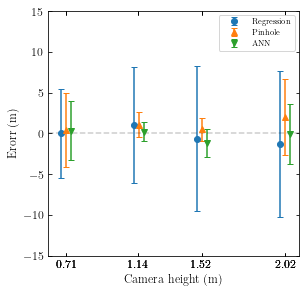

In [34]:
fig = plt.figure(figsize=(4.5,4.5))
ax1 = fig.add_subplot(111)
ax1.set_xlabel('Camera height (m)', fontsize=12, style = 'italic', weight='bold')
ax1.set_ylabel('Erorr (m)', fontsize=12,style = 'italic', weight='bold')
trans1 = ax1.transData + ScaledTranslation(-5/72, 0, fig.dpi_scale_trans)
trans2 = ax1.transData + ScaledTranslation(0, 0, fig.dpi_scale_trans)
trans3 = ax1.transData + ScaledTranslation(+5/72, 0, fig.dpi_scale_trans)
ax1.set_xlim([0.6,2.1])
ax1.set_ylim([-15,15])
ax1.errorbar(df_car[df_car.model == 'reg'].unit_m.values, df_car[df_car.model == 'reg']['mean'].values,
             yerr=df_car[df_car.model == 'reg']['std'].values,marker="o", linestyle="none", transform = trans1,
            label = 'Regression')
ax1.errorbar(df_car[df_car.model == 'pin'].unit_m.values, df_car[df_car.model == 'pin']['mean'].values ,
             yerr=df_car[df_car.model == 'pin']['std'].values,marker="^", linestyle="none", transform = trans2,
            label = 'Pinhole')
ax1.errorbar(df_car[df_car.model == 'ann'].unit_m.values, df_car[df_car.model == 'ann']['mean'].values,
             yerr=df_car[df_car.model == 'ann']['std'].values,marker="v", linestyle="none", transform = trans3,
            label = 'ANN')
ax1.legend(loc='best', scatterpoints = 1, fontsize=8)
ax1.axhline(ls = '--', alpha = .2, c='k')
ax1.set_xticks(np.round(df_car.unit_m.values,2))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# plt.savefig('errorbar_truck.pdf',dpi=400)


In [50]:
!pwd

/Users/saeedarabi/Downloads


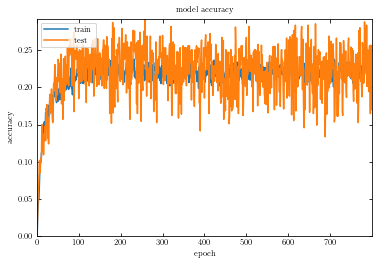

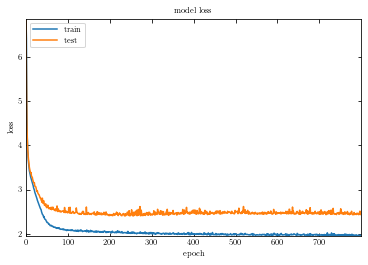

In [35]:
# summarize history for accuracy
plt.plot(history.history['soft_acc'])
plt.plot(history.history['val_soft_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(np.log(history.history['loss']))
plt.plot(np.log(history.history['val_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [355]:
df_ann_test

,H,W,C_x,C_y,unit,vehicle_dummy,gps_dist,predict
0,121.0,166.0,385.0,420.5,45.0,1.0,15.382472,11.134441
1,180.0,204.0,390.0,471.0,28.0,1.0,15.947480,10.421755
2,60.0,78.0,483.0,442.0,60.0,1.0,22.683308,20.302671
3,45.0,50.0,429.0,382.5,45.0,0.0,36.909683,37.129906
4,26.0,40.0,516.0,425.0,60.0,1.0,43.373707,45.295811
...,...,...,...,...,...,...,...,...
470,39.0,44.0,504.0,426.5,28.0,1.0,42.604501,40.996113
471,47.0,50.0,507.0,428.5,28.0,0.0,35.947317,36.435474
472,52.0,56.0,430.0,386.0,45.0,0.0,33.540706,33.804893
473,50.0,56.0,518.0,430.0,60.0,0.0,33.512966,33.870205


Text(0, 0.5, 'Residual (m)')

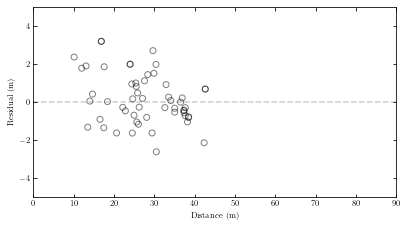

In [364]:
df_tmp_car = df_ann_test[(df_ann_test.vehicle_dummy == 0) & (df_ann_test.unit == 45)] # 0:truck, 1:car
fig = plt.figure(figsize=(6.5,3.5))
ax1 = fig.add_subplot(111)
ax1.scatter(df_tmp_car.gps_dist, df_tmp_car.predict - df_tmp_car.gps_dist, alpha=.5, facecolors='none', edgecolors='k')
ax1.set_xlim([0,90])
ax1.set_ylim([-5,5])
ax1.axhline(ls = '--', alpha = .2, c='k')
dft = df_tmp_car[(df_tmp_car.gps_dist<10) & (df_tmp_car.gps_dist>0)]
ax1.set_xlabel('Distance (m)', fontsize=8, style = 'italic', weight='bold')
ax1.set_ylabel('Residual (m)', fontsize=8,style = 'italic', weight='bold')
# plt.savefig('residuals_truck.pdf',dpi=400)

45.0


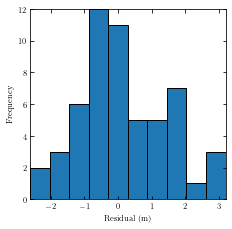

In [365]:
for name, group in df_tmp_car.groupby('unit'):
    print(name)
    fig = plt.figure(figsize=(3.5,3.5))
    ax1 = fig.add_subplot(111)
    ax1.hist(group.predict - group.gps_dist)
    ax1.set_xlabel('Residual (m)', fontsize=8, style = 'italic', weight='bold')
    ax1.set_ylabel('Frequency', fontsize=8,style = 'italic', weight='bold')
    plt.savefig('dist_truck_{}.pdf'.format(name),dpi=400)

In [ ]:
def f(x):
    val = x['y_pred'] - x['y_test']
    return pd.Series([np.mean(val), np.std(val), iqr(val)]).reset_index(drop = True)

df = pd.DataFrame(sc.inverse_transform(X_test), columns=['H', 'W', 'C_x', 'C_y', 'unit', 'vehicle'])
df['y_pred'] = y_pred
df['y_test'] = y_test
df = df[df['vehicle'] == 0]

# df = df.groupby('unit')

df = df.groupby('unit').apply(f).reset_index()
df.columns = ['unit_h', 'deep model mean', 'deep model std','deep model iqr' ]
df['unit_name'] = [ "Unit 13 \n (0.71)", "Unit 10 \n (1.14 m)", "Unit 12 \n (1.52)", "Unit 17 \n (2 m)"]
df.index = df['unit_name']

In [ ]:
df.head()

In [ ]:
for name, group in df:
    print(name)
    plt.figure()
    plt.hist(group.y_pred - group.y_test)
    plt.show()

In [ ]:
df['truck_mean'] = df_truck.mean().values
df['truck_std'] = df_truck.std()
df['truck_iqr'] = iqr(df_truck, axis = 0)
df['car_mean'] = df_car.mean()
df['car_std'] = df_car.std()
df['car_iqr'] = iqr(df_car, axis = 0)

df

In [ ]:
mean_truck = [-0.2492995561347824]
std_truck = [2.70862288681874]
std_car = [3.7408812882449993]
mean_car = [-0.12542908901759484]
print([df_truck.values.mean(), df_car.dropna().values.mean()])
print([df_truck.values.std(), df_car.dropna().values.std()])

In [ ]:
df[['unit_h', 'deep model mean', 'deep model std', 'deep model iqr',
        'truck_mean', 'truck_std', 'truck_iqr', 'car_mean',
       'car_std', 'car_iqr']]

In [ ]:
plt.figure(figsize=(5,15))
df[['deep model mean', 'truck_mean']].plot(kind='bar', yerr=df[['deep model std', 'truck_std']].values.T, xlabel='unit', ylabel='error (m)', figsize=(10,5)) 
plt.legend(["Deep model", 'Pinhole model'])

In [ ]:
ax = df.mean().plot(legend=False,kind="bar",
                          color="red",rot=0,fontsize=16,yerr=df.std(), figsize=(6.5,6.5))
font = font_manager.FontProperties(family = fontname, style='italic', size=14)
plt.xticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.yticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.xlabel('Units', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
plt.ylabel('Distance Error (m)', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
ax.set_ylim((-5,5))


In [ ]:
plt.figure(figsize=(15,3))
plt.scatter(range(len(y_test)), y_test, color = 'red', label = 'Real data')
plt.scatter(range(len(y_pred)), y_pred, color = 'blue', label = 'Predicted data')
plt.figure(figsize=(15, 3))
plt.scatter(range(len(y_pred)), (y_test - y_pred), color = 'blue', label = 'Predicted data')
plt.title('Prediction')
plt.legend()
plt.show()

In [ ]:
np.std(y_test - y_pred)

In [ ]:
np.mean(y_test - y_pred)

In [ ]:
iqr(y_test - y_pred)

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x=y_test.reshape(713,1), y=(y_pred.reshape(713,1) - y_test.reshape(713,1)), alpha=.2, facecolors='none', edgecolors='r')
# plt.gca().update(dict(xlabel='y_test', ylabel='residuals (y_pred - y_test)'))

In [ ]:
plt.figure(figsize=(10,5))
plt.scatter(x=y_test.reshape(713,1), y=(y_pred.reshape(713,1) - y_test.reshape(713,1)), alpha=.2, facecolors='none', edgecolors='r')

In [ ]:
columns = [ "Unit 13 \n (0.71)", "Unit 10 \n (1.14 m)", "Unit 12 \n (1.52)", "Unit 17 \n (2 m)"]
truck = [[0.056918, 0.265463, 0.213490, -0.082971],
[0.271355, 1.127730, 1.28477, 1.969870],
[0.392258, 0.318478, -0.042042, 0.520576],
[0.744019, 1.485808, 1.618756, 0.043278],
[ -0.013213, -0.249351, -0.274474, -0.067475],
[0.629137, 0.425123, 0.254424, 0.642990],
[0.204234, 0.661938, 0.512799, -0.007783],
[0.238437, 0.194066, -0.161833, -0.180112]]
df_truck = pd.DataFrame(truck, columns=columns)

ax = df_truck.mean().plot(legend=False,kind="bar",
                          color="red",rot=0,fontsize=16,yerr=df_truck.std(), figsize=(6.5,6.5))
font = font_manager.FontProperties(family = fontname, style='italic', size=14)
plt.xticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.yticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.xlabel('Units', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
plt.ylabel('Distance Error (m)', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
ax.set_ylim((-5,5))

In [ ]:
df_truck.head()

In [ ]:
df_truck.mean().values

In [ ]:
columns = [ "Unit 13 \n (0.71)", "Unit 10 \n (1.14 m)", "Unit 12 \n (1.52)", "Unit 17 \n (2 m)"]
car = [[-0.142094, -0.052965, 0.157796, 0.289925],
[-0.954387, -1.601214, 3.888085, -0.012008],
[0.926389, 2.075867, -0.298162, -1.160564], 
[3.827156, 1.483507, -0.245916, -0.611535], 
[-1.718267, 0.712902, 0.575612, 0.341381],
[np.nan, -0.944339, -0.768733, -1.230775],
[0.859783, 1.272305, -0.411629, 0.732448],
[1.329752, -0.407789, np.nan , 1.783246]]
df_car = pd.DataFrame(car, columns=columns)
df_car.dropna(inplace=True)

In [ ]:
df_car

In [ ]:
ax = df_car.mean().plot(legend=False,kind="bar",
                          color="red",rot=0,fontsize=10,yerr=df_car.std(), figsize=(6.5,6.5))
font = font_manager.FontProperties(family = fontname, style='italic', size=14)
plt.xticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.yticks(weight = 'bold', style = 'italic', fontname = fontname, fontsize=14)
plt.xlabel('Units', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
plt.ylabel('Distance Error (m)', fontsize=16,style = 'italic', weight='bold', fontname=fontname)
ax.set_ylim((-5, 5))